## 1. Setup del Notebook

### 1.1 Importación de Librerias

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import warnings
warnings.filterwarnings("ignore")

In [5]:
pd.set_option('display.max_columns', None)

### 1.2 Lectura de Archivos

In [6]:
df = pd.read_csv("../../data/features/dentix_model_input.csv")
df.head()

,TRANSACTION ID,NO PERSONAS A CARGO,ANTIGUEDAD EN LA CIUDAD tiempo en residencia,ESTRATO,INGRESOS FIJOS,TOTAL INGRESOS,CUOTA DE CREDITOS,GASTOS DE SOSTENIMIENTO,TOTAL EGRESOS,ACTIVOS,PASIVOS,MONTO PREAPROBADO,NO CREDITO,MONTO APROBADO,PLAZO,MONTO DESEMBOLSO,IDENTIFICACION COMERCIAL,TASA,CUOTAMENSUAL,CODIGO CIIU,OPERACION MONEDA EXTRAGERA,SCORE,SEGURO,AVAL,CODIGO CONFIRMACION CREDITO,PAGARE_ID,NUMERO CREDITO TESEO,SALDO CAPITAL,SALDO VENCIDO,DIAS DE MORA,FRANJA DE MORA,SALDO VENCIDO_LOG,DIAS DE MORA _LOG,TOTAL INGRESOS_LOG,INGRESOS FIJOS_LOG,MONTO APROBADO_LOG,MONTO PREAPROBADO_LOG,PASIVOS_LOG,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,GASTOS DE SOSTENIMIENTO_YJ,MONTO PREAPROBADO_YJ,MONTO APROBADO_YJ,MONTO DESEMBOLSO_YJ,SEGURO_YJ,AVAL_YJ,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,INCIDENCIAFORMALIZACION_Albania,INCIDENCIAFORMALIZACION_Argentina,INCIDENCIAFORMALIZACION_Armenia,INCIDENCIAFORMALIZACION_Belgica,INCIDENCIAFORMALIZACION_China,"INCIDENCIAFORMALIZACION_Cocos (Keeling), Islas",INCIDENCIAFORMALIZACION_Colombia,INCIDENCIAFORMALIZACION_Ecuador,INCIDENCIAFORMALIZACION_España,INCIDENCIAFORMALIZACION_Estados Unidos,INCIDENCIAFORMALIZACION_Honduras,INCIDENCIAFORMALIZACION_Italia,INCIDENCIAFORMALIZACION_Mexico,INCIDENCIAFORMALIZACION_Panama,INCIDENCIAFORMALIZACION_Puerto Rico,INCIDENCIAFORMALIZACION_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Denti

## 2. Preparación de Datos

### 2.1 Comprensión inicial

In [4]:
target = "MONTO APROBADO YJ"


df_model = df[features + [target]].dropna()
df_model.head()


target_mora30
0    0.855574
1    0.144426
Name: proportion, dtype: float64

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34156 entries, 0 to 34155
Data columns (total 160 columns):
 #    Column                                                                                                                    Dtype  
---   ------                                                                                                                    -----  
 0    TRANSACTION ID                                                                                                            int64  
 1    NO PERSONAS A CARGO                                                                                                       float64
 2    ANTIGUEDAD EN LA CIUDAD tiempo en residencia                                                                              float64
 3    ESTRATO                                                                                                                   float64
 4    INGRESOS FIJOS                                                      

### 2.2 Selección inicial de variables

In [6]:
yj_cols = [col for col in df.columns if col.endswith("_YJ")]

onehot_cols = df.select_dtypes(include=['bool']).columns.tolist()

other_cols = ['TRANSACTION ID', 'ESTRATO', 'SCORE', 'CUOTA DE CREDITOS',
              'TOTAL EGRESOS', 'ACTIVOS', 'PLAZO', 'TASA', 'CUOTAMENSUAL',
              'NIVEL ESTUDIOS_ORD', 'PROFESION_FREQ', 'CIUDAD_FREQ',
              'COMERCIAL_FREQ', 'DEPARTAMENTO_FREQ', 'target_mora30']

cols_finales = yj_cols + onehot_cols + other_cols

df_yj_onehot = df[cols_finales].copy()
df_yj_onehot = df_yj_onehot.set_index("TRANSACTION ID")

pattern = re.compile(r"^INCIDENCIA[\s_]*FORMALIZACION", re.IGNORECASE)

cols_to_drop = [c for c in df_yj_onehot.columns if pattern.search(c)]
print("A borrar:", cols_to_drop)

if not cols_to_drop:
    pattern2 = re.compile(r"^INCIDENCIA[\s_]*FORMALIZACION.*_YJ$", re.IGNORECASE)
    cols_to_drop = [c for c in df_yj_onehot.columns if pattern2.search(c)]
    print("Variante _YJ a borrar:", cols_to_drop)

df_yj_onehot = df_yj_onehot.drop(columns=cols_to_drop)
df_yj_onehot.head()

A borrar: ['INCIDENCIAFORMALIZACION_Albania', 'INCIDENCIAFORMALIZACION_Argentina', 'INCIDENCIAFORMALIZACION_Armenia', 'INCIDENCIAFORMALIZACION_Belgica', 'INCIDENCIAFORMALIZACION_China', 'INCIDENCIAFORMALIZACION_Cocos (Keeling), Islas', 'INCIDENCIAFORMALIZACION_Colombia', 'INCIDENCIAFORMALIZACION_Ecuador', 'INCIDENCIAFORMALIZACION_España', 'INCIDENCIAFORMALIZACION_Estados Unidos', 'INCIDENCIAFORMALIZACION_Honduras', 'INCIDENCIAFORMALIZACION_Italia', 'INCIDENCIAFORMALIZACION_Mexico', 'INCIDENCIAFORMALIZACION_Panama', 'INCIDENCIAFORMALIZACION_Puerto Rico', 'INCIDENCIAFORMALIZACION_Venezuela']


,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,GASTOS DE SOSTENIMIENTO_YJ,MONTO PREAPROBADO_YJ,MONTO APROBADO_YJ,MONTO DESEMBOLSO_YJ,SEGURO_YJ,AVAL_YJ,OPERACION MONEDA EXTRAGERA,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Dentix MDE Av. Poblado Medellín,CLINICA_Dentix MDE Envigado,CLINICA_Dentix MDE Fabricato Multialiado,CLINICA_Dentix MDE Itagüi Mayorca,CLINICA_Dentix MTR Montería,CLINICA_Dentix MZL Cra. 23 Manizales,CLINICA_Dentix NVA Neiva,CLINICA_Dentix PEI Pereira,CLINICA_Dentix PPN Popayán,CLINICA_Dentix PPN Popayán Campanario,CLINICA_Dentix PSO Pasto,CLINICA_Dentix SMR Santa Marta,CLINICA_Dentix TUN Tunja,CLINICA_Dentix VUP Valledupar,CLINICA_Dentix VVC Primavera Villavicencio,ESTRATO,SCORE,CUOTA DE CREDITOS,TOTAL EGRESOS,ACTIVOS,PLAZO,TASA,CUOTAMENSUAL,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ,target_mora30
TRANSACTION ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016918,1.550697,1.659905,-1.342884,2.274419,2.274626,2.274398,2.274323,2.172652,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,Fa

### 2.2  Correlaciones & Multicolinealidad Inicial

<Axes: >

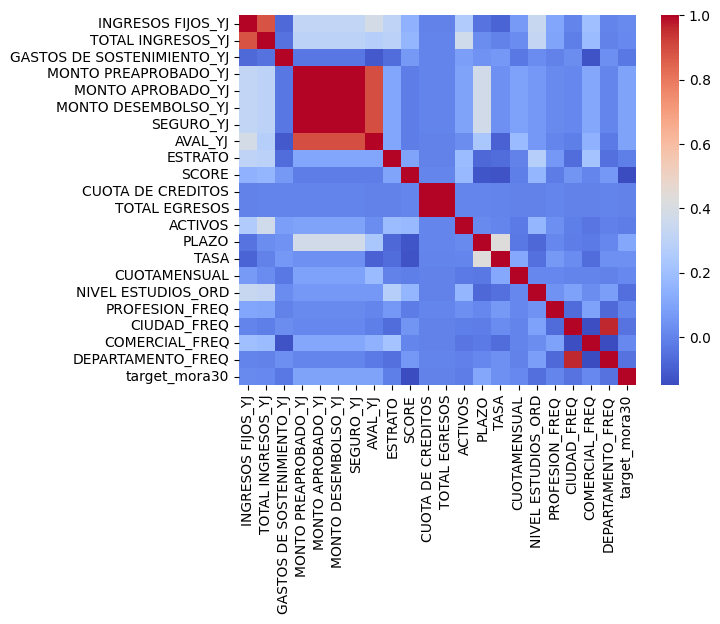

In [7]:
sns.heatmap(df_yj_onehot.select_dtypes("number").corr(), cmap="coolwarm")

### 2.3 Validación de Supuestos de Regresión Logística

#### 2.3.1. Supuesto 2 — Multicolinealidad baja

In [8]:
df_vif = df_yj_onehot.copy()

onehot_cols = [c for c in onehot_cols if c in df_yj_onehot.columns]
df_vif[onehot_cols] = df_vif[onehot_cols].astype(int)

X = df_vif.drop(columns=["target_mora30"])

X = X.dropna().copy()

cols_constantes = [c for c in X.columns if X[c].std() == 0]
X = X.drop(columns=cols_constantes)

In [9]:
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values("VIF")

,variable,VIF
8,OPERACION MONEDA EXTRAGERA,1.011257e+00
35,LUGAR NACIMIENTO_Argentina,1.011570e+00
46,LUGAR NACIMIENTO_Mexico,1.012362e+00
48,LUGAR NACIMIENTO_Puerto Rico,1.013462e+00
36,LUGAR NACIMIENTO_Armenia,1.013557e+00
...,...,...
3,MONTO PREAPROBADO_YJ,5.636386e+04
6,SEGURO_YJ,1.264301e+05
5,MONTO DESEMBOLSO_YJ,1.655847e+05
103,CUOTA DE CREDITOS,7.453920e+07


In [10]:
vif[vif["VIF"] > 10]

,variable,VIF
3,MONTO PREAPROBADO_YJ,5.636386e+04
4,MONTO APROBADO_YJ,1.716681e+04
5,MONTO DESEMBOLSO_YJ,1.655847e+05
6,SEGURO_YJ,1.264301e+05
7,AVAL_YJ,1.069934e+01
13,TIPO VIVIENDA_Familiar,1.849016e+01
14,TIPO VIVIENDA_Propia,1.596646e+01
18,ACTIVIDAD ECONÓMICA_Asalariados,3.795306e+01
19,ACTIVIDAD ECONÓMICA_Comercio al por mayor a ca...,1.063314e+01
24,TIPO CONTRATO_Indefinido,2.034994e+01


#### 2.3.2. Supuesto 3 — Linealidad del logit

In [11]:
features_final = [

    # Numéricas YJ
    "INGRESOS FIJOS_YJ",
    "TOTAL INGRESOS_YJ",
    "GASTOS DE SOSTENIMIENTO_YJ",
    "TOTAL EGRESOS",
    "ACTIVOS",
    "SCORE",
    "MONTO APROBADO_YJ",

    # Ordinales / Frecuencias
    "ESTRATO",
    "NIVEL ESTUDIOS_ORD",
    "CIUDAD_FREQ",
    "PROFESION_FREQ",
    "COMERCIAL_FREQ",

    # Estado civil
    "ESTADOCIVIL_Unión libre",
    "ESTADOCIVIL_Soltero (a)",

    # Tipo contrato
    "TIPO CONTRATO_Indefinido",
    "TIPO CONTRATO_Prestación de servicios",

    # Ocupación
    "OCUPACIÓN_Empleado",
    "OCUPACIÓN_Independiente",

    # Tipo vivienda
    "TIPO VIVIENDA_Propia",
    "TIPO VIVIENDA_Familiar",

    # Actividad económica
    "ACTIVIDAD ECONÓMICA_Asalariados",
    "ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.",
]


In [12]:
X = df_yj_onehot[features_final].copy()
X = X.apply(lambda col: col.astype(int) if col.dtype == bool else col)
X = X.apply(pd.to_numeric, errors="coerce")
X = X.dropna()

X = sm.add_constant(X)
y = df_yj_onehot.loc[X.index, "target_mora30"]
modelo = sm.Logit(y, X).fit()
modelo.summary()

D:\CodingTools\Python\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.394542
         Iterations 11


D:\CodingTools\Python\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          target_mora30   No. Observations:                34156
Model:                          Logit   Df Residuals:                    34133
Method:                           MLE   Df Model:                           22
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                 0.04450
Time:                        15:56:44   Log-Likelihood:                -13476.
converged:                       True   LL-Null:                       -14104.
Covariance Type:            nonrobust   LLR p-value:                7.204e-252
=========================================================================================================================================================
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                    -2.1467      0.114    -18.912      0.000      -2.369      -1.924
INGRESOS FIJOS_YJ                                                                         0.0122      0.040      0.304      0.761      -0.066       0.090
TOTAL INGRESOS_YJ                                                                         0.0493      0.039      1.270      0.204      -0.027       0.125
GASTOS DE SOSTENIMIENTO_YJ                                                               -0.0298      0.017     -1.798      0.072      -0.062       0.003
TOTAL EGRESOS                                                                           -17.9043      4.262     -4.201      0.000     -26.258      -9.551
ACTIVOS                                                                                  -0.0062      0.018     -0.336      0.737      -0.042       0.030
SCORE                                                                                    -0.4141      0.017    -23.729      0.000      -0.448      -0.380
MONTO APROBADO_YJ                                                                         0.2613      0.017     15.114      0.000       0.227       0.295
ESTRATO                                                                                  -0.0171      0.017     -0.982      0.326      -0.051       0.017
NIVEL ESTUDIOS_ORD                                                                       -0.1272      0.017     -7.283      0.000      -0.161      -0.093
CIUDAD_FREQ                                                                              -0.0985      0.017     -5.728      0.000      -0.132      -0.065
PROFESION_FREQ                                                                           -0.0197      0.016     -1.209      0.227      -0.052       0.012
COMERCIAL_FREQ                                                                           -0.0097      0.017     -0.574      0.566      -0.043       0.023
ESTADOCIVIL_Unión libre                                                                   0.1512      0.055      2.754      0.006       0.044       0.259
ESTADOCIVIL_Soltero (a)                                                                   0.1319      0.042      3.152      0.002       0.050       0.214
TIPO CONTRATO_Indefinido                                                                  0.2658      0.074      3.609      0.000       0.121       0.410
TIPO CONTRATO_Prestación de servicios                                                     0.1784      0.080      2.225      0.026       0.021       0.335
OCUPACIÓN_Empleado                                                                       -0.2065      0.112     -1.847      0.065      -0.426       0.013
OCUPACI

#### 2.3.3. Supuesto 4 — Ausencia de outliers influyentes (Cook’s distance)

In [13]:
influence = modelo.get_influence()
summary_frame = influence.summary_frame()

D:\CodingTools\Python\Lib\site-packages\statsmodels\discrete\discrete_model.py:5312: RuntimeWarning: invalid value encountered in divide
  return (endog - M*p)/np.sqrt(M*p*(1-p))
D:\CodingTools\Python\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
D:\CodingTools\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:644: RuntimeWarning: invalid value encountered in divide
  return self.d_fittedvalues / self._get_prediction.se


In [14]:
cooks_d = summary_frame["cooks_d"]

In [15]:
threshold = 4 / len(X)   # regla estándar
puntos_influyentes = cooks_d[cooks_d > threshold]
puntos_influyentes.head()

TRANSACTION ID
2007210    0.000279
2006576    0.000136
2006518    0.000284
2005994    0.000321
2005576    0.000372
Name: cooks_d, dtype: float64

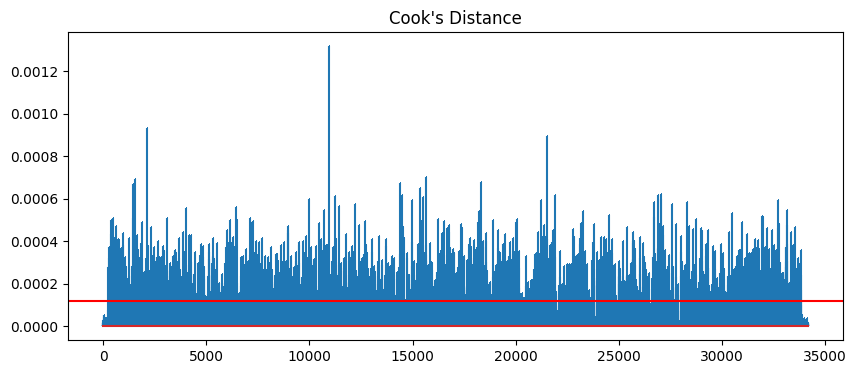

In [16]:
plt.figure(figsize=(10,4))
plt.stem(cooks_d, markerfmt=",")
plt.axhline(threshold, color="red")
plt.title("Cook's Distance")
plt.show()

## 3. División de Datos

In [17]:
cols_to_drop = [
    "GASTOS DE SOSTENIMIENTO_YJ",
    "MONTO PREAPROBADO_YJ",
    "MONTO DESEMBOLSO_YJ",
    "SEGURO_YJ",
    "AVAL_YJ"
]

df_yj_onehot = df_yj_onehot.drop(columns=cols_to_drop, errors="ignore")
df_yj_onehot = df_yj_onehot.reset_index()

df_yj_onehot.head()

,TRANSACTION ID,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,MONTO APROBADO_YJ,OPERACION MONEDA EXTRAGERA,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Dentix MDE Av. Poblado Medellín,CLINICA_Dentix MDE Envigado,CLINICA_Dentix MDE Fabricato Multialiado,CLINICA_Dentix MDE Itagüi Mayorca,CLINICA_Dentix MTR Montería,CLINICA_Dentix MZL Cra. 23 Manizales,CLINICA_Dentix NVA Neiva,CLINICA_Dentix PEI Pereira,CLINICA_Dentix PPN Popayán,CLINICA_Dentix PPN Popayán Campanario,CLINICA_Dentix PSO Pasto,CLINICA_Dentix SMR Santa Marta,CLINICA_Dentix TUN Tunja,CLINICA_Dentix VUP Valledupar,CLINICA_Dentix VVC Primavera Villavicencio,ESTRATO,SCORE,CUOTA DE CREDITOS,TOTAL EGRESOS,ACTIVOS,PLAZO,TASA,CUOTAMENSUAL,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ,target_mora30
0,2016918,1.550697,1.659905,2.274626,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.596071,-0.497084,-0.008909,-0.00908

In [18]:
df_fechas = pd.read_excel("../../data/raw/BaseDentix.xlsx")
cols_keep = ["TRANSACTION ID", "FECHA SOLICITUD"]
df_fechas = df_fechas[cols_keep].copy()
df_fechas.head()

,TRANSACTION ID,FECHA SOLICITUD
0,2016918,2025-06-17 19:17:46
1,2016914,2025-06-17 19:08:42
2,2016836,2025-06-17 17:46:00
3,2016736,2025-06-17 16:27:25
4,2016576,2025-06-17 13:54:04


In [19]:
id_col = "TRANSACTION ID"
fecha_col = "FECHA SOLICITUD"

df_model = df_yj_onehot.copy()

df_merged = df_model.merge(
    df_fechas,
    how="inner",
    on=id_col
)

In [20]:
df_merged[fecha_col] = pd.to_datetime(df_merged[fecha_col], errors="coerce")
df_merged = df_merged.sort_values('FECHA SOLICITUD')

In [21]:
cols_to_drop = [
    'PLAZO', 'TASA', 'CUOTAMENSUAL', 'CUOTA DE CREDITOS'
    
]
df_merged = df_merged.drop(columns = cols_to_drop)
df_merged = df_merged.dropna(subset=[fecha_col])

In [22]:
print(list(df_merged.columns))

['TRANSACTION ID', 'INGRESOS FIJOS_YJ', 'TOTAL INGRESOS_YJ', 'MONTO APROBADO_YJ', 'OPERACION MONEDA EXTRAGERA', 'ESTADOCIVIL_Divorciado (a) / Separado (a)', 'ESTADOCIVIL_Soltero (a)', 'ESTADOCIVIL_Unión libre', 'ESTADOCIVIL_Viudo (a)', 'TIPO VIVIENDA_Familiar', 'TIPO VIVIENDA_Propia', 'TIPO VIVIENDA_Propia con crédito', 'ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.', 'ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.', 'ACTIVIDAD ECONÓMICA_Asalariados', 'ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.', 'ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.', 'ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.', 'ACTIVIDAD ECONÓMICA_Pensionados', 'ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.', 'TIPO CONTRATO_Indefinido', 'TIPO CONTRATO_No Aplica', 'TIPO CONT

In [23]:
split = int(len(df_merged) * 0.8)

train = df_merged.iloc[:split].copy()
test  = df_merged.iloc[split:].copy()

In [24]:
train

,TRANSACTION ID,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,MONTO APROBADO_YJ,OPERACION MONEDA EXTRAGERA,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Dentix MDE Av. Poblado Medellín,CLINICA_Dentix MDE Envigado,CLINICA_Dentix MDE Fabricato Multialiado,CLINICA_Dentix MDE Itagüi Mayorca,CLINICA_Dentix MTR Montería,CLINICA_Dentix MZL Cra. 23 Manizales,CLINICA_Dentix NVA Neiva,CLINICA_Dentix PEI Pereira,CLINICA_Dentix PPN Popayán,CLINICA_Dentix PPN Popayán Campanario,CLINICA_Dentix PSO Pasto,CLINICA_Dentix SMR Santa Marta,CLINICA_Dentix TUN Tunja,CLINICA_Dentix VUP Valledupar,CLINICA_Dentix VVC Primavera Villavicencio,ESTRATO,SCORE,TOTAL EGRESOS,ACTIVOS,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ,target_mora30,FECHA SOLICITUD
33854,1173611,-1.249129,0.025675,0.834083,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,-2.261856,0.125449,0.000164,1.202365,0.842079,-0.931155,-

## 4. Preprocesamiento

In [25]:
datetime_cols = train.select_dtypes(include=["datetime64[ns]"]).columns.tolist()

X_train = train.drop(columns=["target_mora30"] + datetime_cols)
y_train = train["target_mora30"]

X_test = test.drop(columns=["target_mora30"] + datetime_cols)
y_test = test["target_mora30"]

In [26]:
print(list(X_train.columns))

['TRANSACTION ID', 'INGRESOS FIJOS_YJ', 'TOTAL INGRESOS_YJ', 'MONTO APROBADO_YJ', 'OPERACION MONEDA EXTRAGERA', 'ESTADOCIVIL_Divorciado (a) / Separado (a)', 'ESTADOCIVIL_Soltero (a)', 'ESTADOCIVIL_Unión libre', 'ESTADOCIVIL_Viudo (a)', 'TIPO VIVIENDA_Familiar', 'TIPO VIVIENDA_Propia', 'TIPO VIVIENDA_Propia con crédito', 'ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.', 'ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.', 'ACTIVIDAD ECONÓMICA_Asalariados', 'ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.', 'ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.', 'ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.', 'ACTIVIDAD ECONÓMICA_Pensionados', 'ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.', 'TIPO CONTRATO_Indefinido', 'TIPO CONTRATO_No Aplica', 'TIPO CONT

In [27]:
num_cols = ['INGRESOS FIJOS_YJ','TOTAL INGRESOS_YJ','MONTO APROBADO_YJ',
            'SCORE','TOTAL EGRESOS','ACTIVOS']

preprocessor = StandardScaler()

## 5. MODELO 1 – Regresión Logística (Modelo Oficial)

### 5.1 Pipeline & Entrenamiento

In [28]:
logreg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=200))
])

logreg.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


### 5.2 Predicción

In [29]:
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

### 5.3 Métricas

In [30]:
metricas = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC_AUC': roc_auc_score(y_test, y_prob)
}
metricas

{'Accuracy': 0.829771662763466,
 'Precision': 0.7142857142857143,
 'Recall': 0.004288164665523156,
 'ROC_AUC': 0.6190252530970751}

### 5.4 Matriz de Confusión

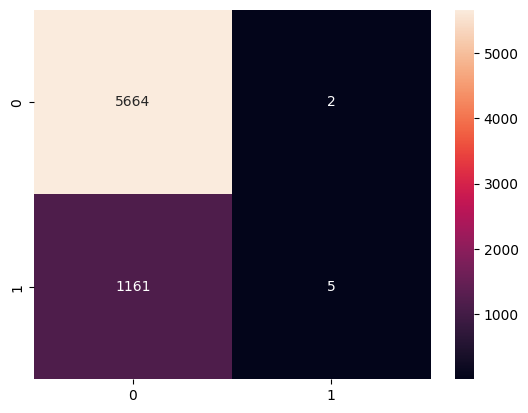

In [31]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()

### 5.5 Curva de ROC

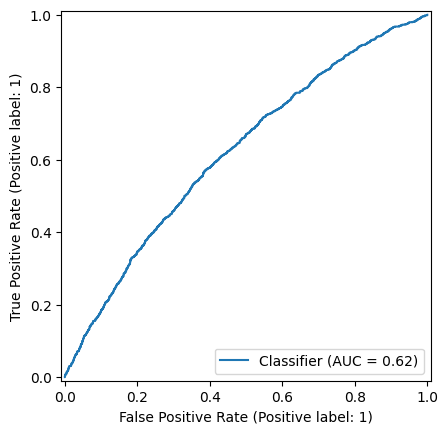

In [32]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

## 6. Modelos Alternos (Árbol – RandomForest – XGBoost)

### 6.1 Definimos los Modelos

In [33]:
tree = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', DecisionTreeClassifier(max_depth=6, random_state=42))
])

rf = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

xgb = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', XGBClassifier(
        max_depth=5,
        n_estimators=300,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    ))
])


In [34]:
def evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1]
    
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

In [35]:
resultados = []

resultados.append(
    evaluar_modelo("Árbol", tree, X_train, y_train, X_test, y_test)
)

resultados.append(
    evaluar_modelo("Random Forest", rf, X_train, y_train, X_test, y_test)
)

resultados.append(
    evaluar_modelo("XGBoost", xgb, X_train, y_train, X_test, y_test)
)


D:\CodingTools\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [36]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Accuracy,Precision,Recall,ROC_AUC
0,Árbol,0.826844,0.130435,0.002573,0.586593
1,Random Forest,0.828015,0.090909,0.000858,0.583261
2,XGBoost,0.829333,0.000000,0.000000,0.583691


### 6.4 Importancia de Variables en RF y XGB

#### 6.4.1 Importancia en Random Forest

In [37]:
rf_solo = RandomForestClassifier(
    n_estimators=300, random_state=42, n_jobs=-1
)

rf_solo.fit(X_train, y_train)

feat_names = X_train.columns.tolist()

importancias_rf = pd.DataFrame({
    'variable': feat_names,
    'importancia': rf_solo.feature_importances_
}).sort_values('importancia', ascending=False)

importancias_rf.head(20)

,variable,importancia
98,SCORE,0.100105
3,MONTO APROBADO_YJ,0.094168
0,TRANSACTION ID,0.093102
2,TOTAL INGRESOS_YJ,0.075888
99,TOTAL EGRESOS,0.065006
1,INGRESOS FIJOS_YJ,0.063225
102,PROFESION_FREQ,0.059227
100,ACTIVOS,0.055380
104,COMERCIAL_FREQ,0.053712
103,CIUDAD_FREQ,0.032871


#### 6.4.2 Importancia en XGBoost

In [38]:
xgb_solo = XGBClassifier(
    max_depth=5,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_solo.fit(X_train, y_train)

importancias_xgb = pd.DataFrame({
    'variable': feat_names,
    'importancia': xgb_solo.feature_importances_
}).sort_values('importancia', ascending=False)

importancias_xgb.head(20)

,variable,importancia
98,SCORE,0.027472
0,TRANSACTION ID,0.023738
76,CLINICA_Dentix CTG Cartagena Cc Mallplaza,0.020368
74,CLINICA_Dentix CLO Imbanaco,0.019405
3,MONTO APROBADO_YJ,0.018186
59,CLINICA_Dentix BOG Chia,0.017691
79,CLINICA_Dentix EOH Centro Medellín,0.017240
55,CLINICA_Dentix BOG CC Plaza de las Américas Bo...,0.016714
46,CLINICA_Dentix BAQ Barranquilla,0.015959
101,NIVEL ESTUDIOS_ORD,0.015089


### 6.5 Curvas ROC Comparativas

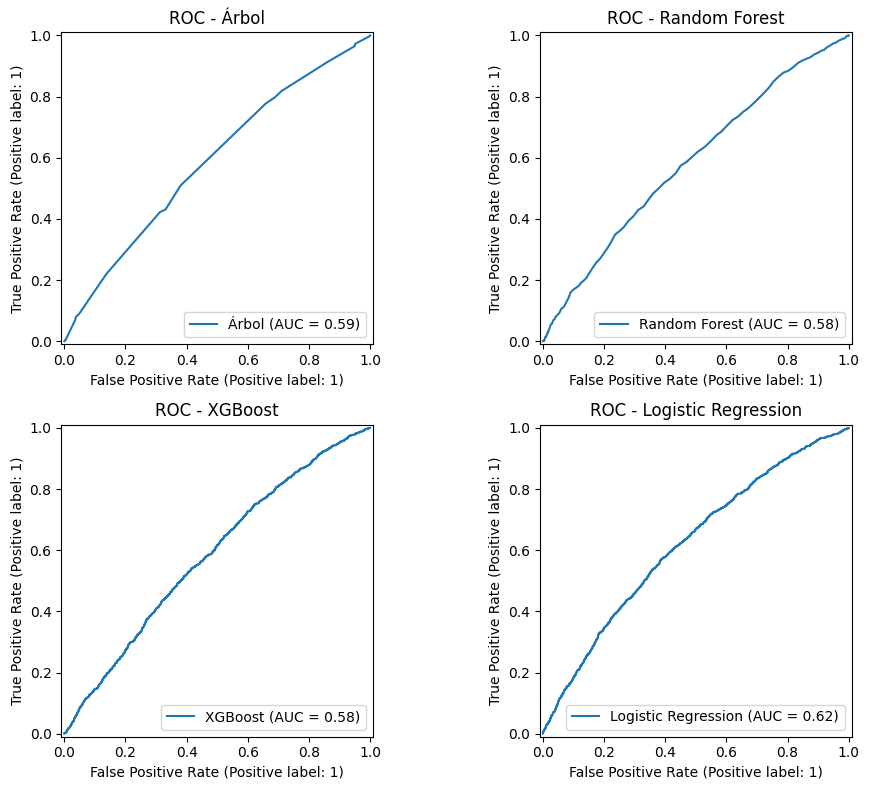

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

modelos = {
    "Árbol": tree,
    "Random Forest": rf,
    "XGBoost": xgb,
    "Logistic Regression": logreg
}

for i, (nombre, modelo) in enumerate(modelos.items()):
    modelo.fit(X_train, y_train)
    y_prob = modelo.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, y_prob, name=nombre, ax=axs[i])
    axs[i].set_title(f"ROC - {nombre}")

plt.tight_layout()
plt.show()

### 6.6 Selección del Mejor Modelo

In [40]:
modelo_ganador = df_resultados.sort_values("ROC_AUC", ascending=False).iloc[0]
modelo_ganador

Modelo          Árbol
Accuracy     0.826844
Precision    0.130435
Recall       0.002573
ROC_AUC      0.586593
Name: 0, dtype: object

In [41]:
def matriz_confusion_modelo(nombre, modelo, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No mora","Mora"],
                yticklabels=["No mora","Mora"])
    plt.title(f"Matriz de Confusión — {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


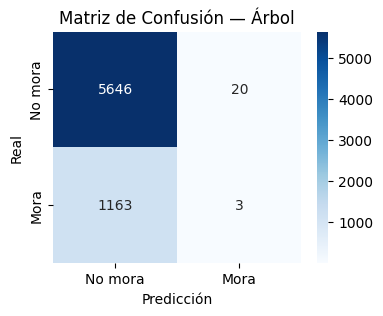

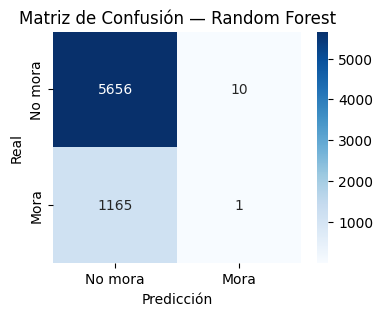

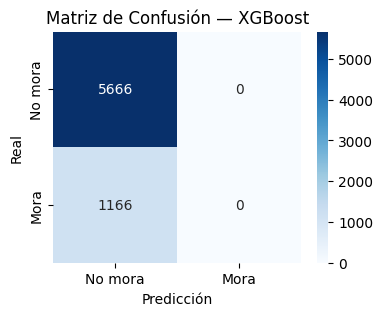

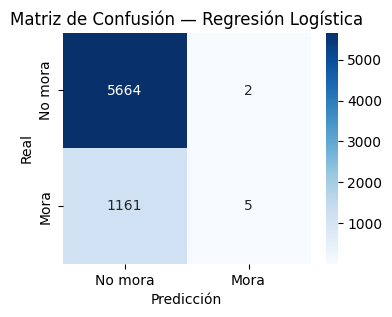

In [42]:
modelos = {
    "Árbol": tree,
    "Random Forest": rf,
    "XGBoost": xgb,
    "Regresión Logística": logreg
}

for nombre, modelo in modelos.items():
    matriz_confusion_modelo(nombre, modelo, X_test, y_test)

## 7. Interpretabilidad (Coeficientes, SHAP, Odds Ratios)

### 7.1 Coeficientes de Regresión Logística (Odds Ratios)

In [43]:
coefs = pd.DataFrame({
    'variable': X_train.columns,
    'coef': logreg.named_steps['model'].coef_[0]
})

coefs['odds_ratio'] = np.exp(coefs['coef'])
coefs['impacto'] = coefs['coef'].apply( lambda x: 'Aumenta Riesgo' if x > 0 else 'Reduce Riesgo')
coefs = coefs.sort_values('odds_ratio', ascending=False)
coefs.head(20)

,variable,coef,odds_ratio,impacto
3,MONTO APROBADO_YJ,0.273501,1.314559,Aumenta Riesgo
20,TIPO CONTRATO_Indefinido,0.124185,1.132225,Aumenta Riesgo
22,TIPO CONTRATO_Prestación de servicios,0.102340,1.107760,Aumenta Riesgo
26,OCUPACIÓN_Pensionado / Jubilado,0.083172,1.086729,Aumenta Riesgo
0,TRANSACTION ID,0.075445,1.078363,Aumenta Riesgo
46,CLINICA_Dentix BAQ Barranquilla,0.073973,1.076777,Aumenta Riesgo
6,ESTADOCIVIL_Soltero (a),0.073264,1.076014,Aumenta Riesgo
103,CIUDAD_FREQ,0.069870,1.072369,Aumenta Riesgo
76,CLINICA_Dentix CTG Cartagena Cc Mallplaza,0.063453,1.065509,Aumenta Riesgo
7,ESTADOCIVIL_Unión libre,0.057059,1.058718,Aumenta Riesgo


C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\3377519878.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20_or, x='odds_ratio', y='variable', palette='viridis')


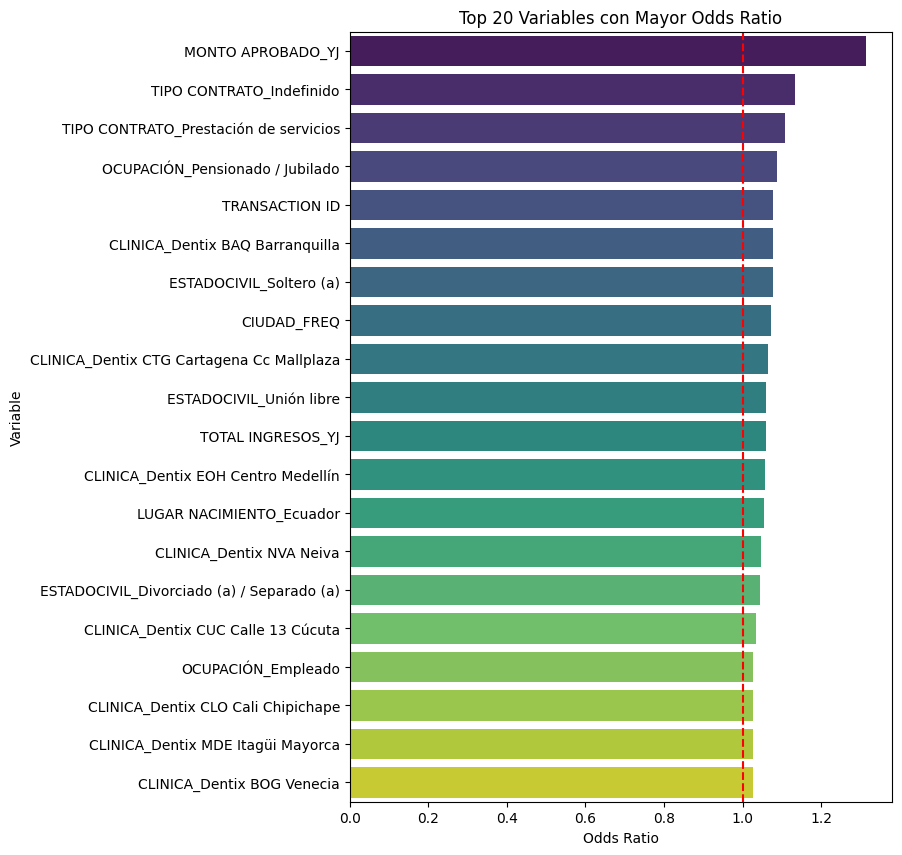

In [44]:
top20_or = coefs.head(20)

plt.figure(figsize=(7,10))
sns.barplot(data=top20_or, x='odds_ratio', y='variable', palette='viridis')
plt.axvline(1, color='red', linestyle='--')
plt.title("Top 20 Variables con Mayor Odds Ratio")
plt.xlabel("Odds Ratio")
plt.ylabel("Variable")
plt.show()

### 7.2 SHAP Values para Modelos

Según Abid All Awan (2023), una de las herramientas más prometedoras para este proceso son los valores SHAP, que miden cuánto contribuye cada característica. Los valores de SHAP (SHapley Additive exPlanations) son una forma de explicar la salida de cualquier modelo de aprendizaje automático, mediante un enfoque de teoría de juegos que mide la contribución de cada jugador al resultado final, le asigna un peso a cada característica de importancia que representa su contribución a la salida del modelo.

In [45]:
num_cols = ['INGRESOS FIJOS_YJ','TOTAL INGRESOS_YJ','MONTO APROBADO_YJ',
            'SCORE','TOTAL EGRESOS','ACTIVOS']

scaler = StandardScaler()
X_train_scaled = X_train.drop('TRANSACTION ID', axis=1).copy()
X_test_scaled = X_test.drop('TRANSACTION ID', axis=1).copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [46]:
xgb_solo = XGBClassifier(
    max_depth=5,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_solo.fit(X_train_scaled, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


D:\CodingTools\Python\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


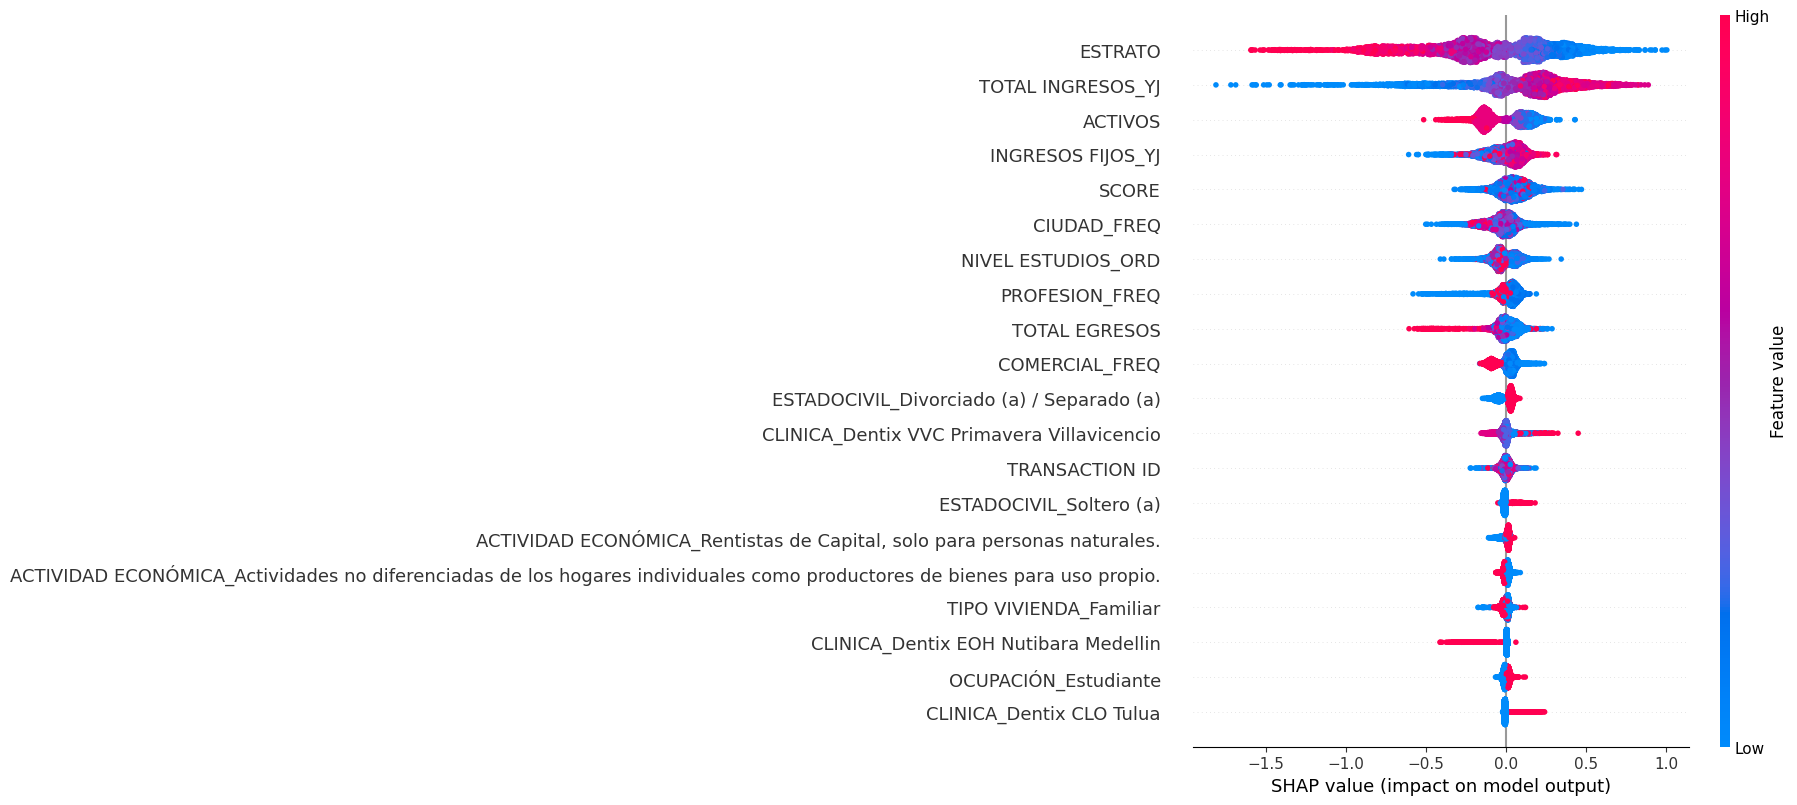

In [47]:
explainer = shap.TreeExplainer(xgb_solo)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

D:\CodingTools\Python\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


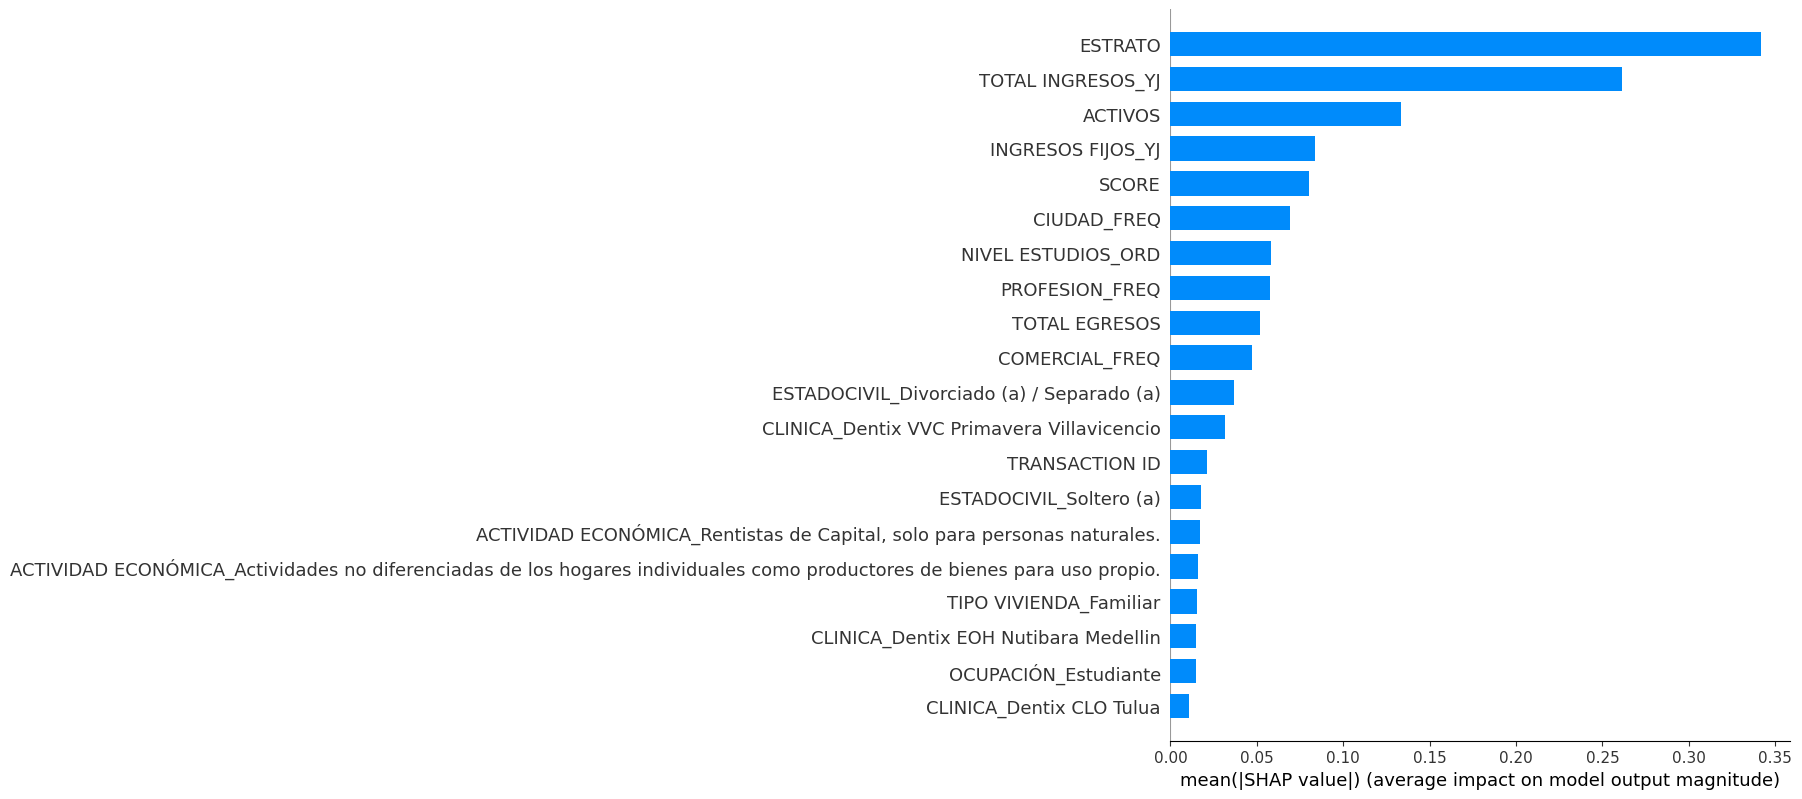

In [48]:
shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=X_train.columns,
    plot_type='bar',
    max_display=20
)

## 8. Errores por Clínica & Asesor 

Agregamos las predicciones al DataFrame de test

In [49]:
test_df = test.copy()

test_df['pred'] = logreg.predict(X_test)
test_df['prob'] = logreg.predict_proba(X_test)[:,1]

Reconstruimos la columna CLÍNICA a partir de dummies 

In [50]:
clinica_cols = [c for c in X_test.columns if c.startswith("CLINICA_")]

test_df['CLINICA'] = test_df[clinica_cols].idxmax(axis=1)

### 8.3 Errores por Clínica

In [51]:
errores_clinica = test_df.groupby('CLINICA').apply(
    lambda x: pd.Series({
        'Casos Totales': len(x),
        'Mora Real (%)': x['target_mora30'].mean()*100,
        'Pred Mora (%)': x['pred'].mean()*100,
        'Falsos Negativos': ((x['target_mora30']==1) & (x['pred']==0)).sum(),
        'Falsos Positivos': ((x['target_mora30']==0) & (x['pred']==1)).sum()
    })
)

errores_clinica.sort_values("Mora Real (%)", ascending=False).head(15)

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\2299417567.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errores_clinica = test_df.groupby('CLINICA').apply(


,Casos Totales,Mora Real (%),Pred Mora (%),Falsos Negativos,Falsos Positivos
CLINICA,,,,,
CLINICA_Dentix BOG Calle 90,1.0,100.000000,0.000000,1.0,0.0
CLINICA_Dentix PPN Popayán Campanario,107.0,32.710280,0.000000,35.0,0.0
CLINICA_Dentix VVC Primavera Villavicencio,54.0,31.481481,0.000000,17.0,0.0
CLINICA_Dentix CTG Cartagena Cc Mallplaza,171.0,29.239766,1.754386,47.0,0.0
CLINICA_Dentix MDE Av. Poblado Medellín,37.0,24.324324,0.000000,9.0,0.0
CLINICA_Dentix PSO Pasto,247.0,24.291498,0.404858,60.0,1.0
CLINICA_Dentix TUN Tunja,171.0,23.391813,0.000000,40.0,0.0
CLINICA_Dentix BAQ Barranquilla,92.0,21.739130,0.000000,20.0,0.0
CLINICA_Dentix MTR Montería,263.0,21.292776,0.380228,55.0,0.0


In [52]:
errores_clinica.sort_values("Falsos Negativos", ascending=False).head(15)

,Casos Totales,Mora Real (%),Pred Mora (%),Falsos Negativos,Falsos Positivos
CLINICA,,,,,
CLINICA_Dentix BAQ Barranquilla Portal del Prado,719.0,20.027816,0.000000,144.0,0.0
CLINICA_Dentix BGA Cl 35 Bucaramanga,506.0,17.984190,0.000000,91.0,0.0
CLINICA_Dentix CLO Av. 100 Cali,442.0,14.479638,0.000000,64.0,0.0
CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,386.0,16.062176,0.000000,62.0,0.0
CLINICA_Dentix PSO Pasto,247.0,24.291498,0.404858,60.0,1.0
CLINICA_Dentix IBE Cra. 5 Ibague,344.0,16.279070,0.000000,56.0,0.0
CLINICA_Dentix MTR Montería,263.0,21.292776,0.380228,55.0,0.0
CLINICA_Dentix BOG Plaza Imperial,311.0,16.398714,0.000000,51.0,0.0
CLINICA_Dentix CTG Cartagena Cc Mallplaza,171.0,29.239766,1.754386,47.0,0.0


## 9. Calibración del Umbral (Threshold Tuning)

Como señaló Foster Provost en su artículo de 2000 titulado "Machine Learning from Imbalanced Data Sets": "En resumen, al estudiar problemas con datos desequilibrados, utilizar los clasificadores producidos por algoritmos estándar de aprendizaje automático sin ajustar el umbral de salida puede ser un error crítico" — Aprendizaje automático a partir de conjuntos de datos desequilibrados 101, 2000.

In [53]:
probs_test = logreg.predict_proba(X_test)[:, 1]

### 9.1 Curva Precision–Recall

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test, probs_test)

precision = precision[:-1]
recall = recall[:-1]
thresholds = thresholds

La curva Precisión-Recall muestra que el threshold por defecto de 0.50 es inadecuado para este problema, pues produce un Recall cercano a cero, lo que significa ---como se observo en las seccciones anteriores--- el modelo prácticamente no detecta morosos. Cuando el umbral se reduce (0.15–0.30), el Recall aumenta significativamente, permitiendo capturar un número mayor de clientes en riesgo, aunque con un incremento en falsos positivos.

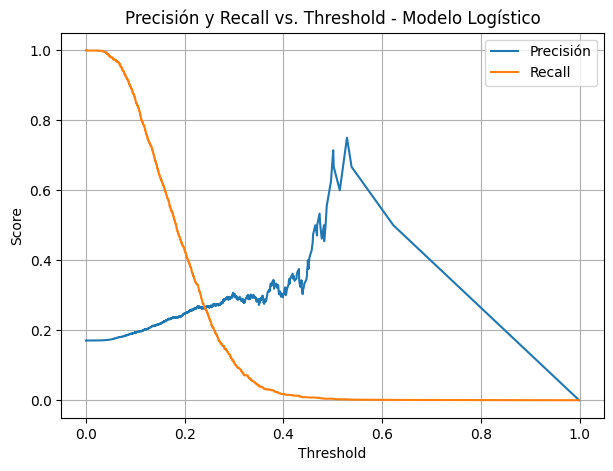

In [55]:
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision, label='Precisión')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precisión y Recall vs. Threshold - Modelo Logístico')
plt.legend()
plt.grid(True)
plt.show()

### 9.2 Threshold óptimo por F1-score

In [56]:
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores, nan=-1)

idx_opt = f1_scores.argmax()
threshold_f1 = thresholds[idx_opt]

threshold_f1, precision[idx_opt], recall[idx_opt], f1_scores[idx_opt]

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\2796471481.py:1: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


(np.float64(0.16734470299202373),
 np.float64(0.2326715430163706),
 np.float64(0.5728987993138936),
 np.float64(0.33093881595243996))

### 9.4 Threshold para el Modelo

In [57]:
THRESHOLD = float(threshold_f1)
THRESHOLD

0.16734470299202373

El threshold por defecto (0.50) produjo Recall cercano a cero, resultando en un modelo incapaz de identificar morosos, ahora, con este nuevo threshold, optimizando F1, se encontró un umbral óptimo en 0.1673, que ofrece un balance adecuado entre precisión (23.2%) y recall (57.3%).

In [58]:
probs_log = logreg.predict_proba(X_test)[:,1]
y_pred_base = (probs_test >= 0.5).astype(int)
y_pred_tuned = (probs_test >= THRESHOLD).astype(int)

## 10. Evaluación Post-Calibración (Matriz de Confusión Ajustada)

### 10.1 Métricas Comparativas

In [59]:
def evaluar_con_threshold(y_true, y_pred, probs):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": 2 * (precision_score(y_true, y_pred, zero_division=0) *
                   recall_score(y_true, y_pred, zero_division=0)) / \
              (precision_score(y_true, y_pred, zero_division=0) +
               recall_score(y_true, y_pred, zero_division=0) + 1e-9),
        "ROC_AUC": roc_auc_score(y_true, probs)
    }

In [60]:
res_base = evaluar_con_threshold(y_test, y_pred_base, probs_test)
res_tuned = evaluar_con_threshold(y_test, y_pred_tuned, probs_test)

df_comp = pd.DataFrame([res_base, res_tuned], index=['Baseline (0.5)', f'Tuned ({THRESHOLD:.3f})'])
df_comp

,Accuracy,Precision,Recall,F1,ROC_AUC
Baseline (0.5),0.829772,0.714286,0.004288,0.008525,0.619025
Tuned (0.167),0.604655,0.232672,0.572899,0.330939,0.619025


### 10.2 Matriz de Confusión Calibrada vs Baseline

In [61]:
def plot_cm(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No mora','Mora'],
                yticklabels=['No mora','Mora'])
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

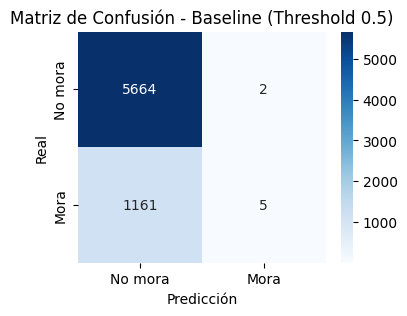

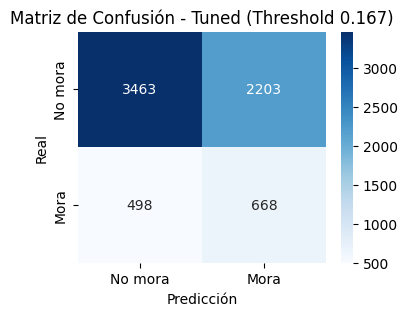

In [62]:
cm_base = confusion_matrix(y_test, y_pred_base)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plot_cm(cm_base, 'Matriz de Confusión - Baseline (Threshold 0.5)')
plot_cm(cm_tuned, f'Matriz de Confusión - Tuned (Threshold {THRESHOLD:.3f})')


### 10.3 Métricas centradas en la clase mora

In [63]:
def resumen_mora(cm):
    tn, fp, fn, tp = cm.ravel()
    return pd.Series({
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "TN": tn,
        "Recall (mora)": tp / (tp + fn + 1e-9),
        "Precision (mora)": tp / (tp + fp + 1e-9)
    })

res_mora_base = resumen_mora(cm_base)
res_mora_tuned = resumen_mora(cm_tuned)

df_mora = pd.DataFrame([res_mora_base, res_mora_tuned],
                       index=['Baseline (0.5)', f'Tuned ({THRESHOLD:.3f})'])
df_mora

,TP,FN,FP,TN,Recall (mora),Precision (mora)
Baseline (0.5),5.0,1161.0,2.0,5664.0,0.004288,0.714286
Tuned (0.167),668.0,498.0,2203.0,3463.0,0.572899,0.232672


A partir de este punto, todas las métricas de errores por clínica y asesor se recalcularán usando el umbral calibrado THRESHOLD, ya que refleja mejor la realidad del riesgo de mora al priorizar la detección de clientes morosos (mayor Recall) con una pérdida controlada en precisión.

### 10.4 Comparación para los Modelos Alternos (Árbol, RF, XGB)

#### 10.4.1 Árbol

In [64]:
probs_tree = tree.predict_proba(X_test)[:,1]
y_tree_base = (probs_tree >= 0.5).astype(int)
y_tree_tuned = (probs_tree >= THRESHOLD).astype(int)

#### 10.4.2 Random Forest

In [65]:
probs_rf = rf.predict_proba(X_test)[:,1]
y_rf_base = (probs_rf >= 0.5).astype(int)
y_rf_tuned = (probs_rf >= THRESHOLD).astype(int)

#### 10.4.3 XGBoost

In [66]:
probs_xgb = xgb.predict_proba(X_test)[:,1]
y_xgb_base = (probs_xgb >= 0.5).astype(int)
y_xgb_tuned = (probs_xgb >= THRESHOLD).astype(int)

In [67]:
models = {
    "Logística": (y_pred_base, y_pred_tuned, probs_test),
    "Árbol": (y_tree_base, y_tree_tuned, probs_tree),
    "Random Forest": (y_rf_base, y_rf_tuned, probs_rf),
    "XGBoost": (y_xgb_base, y_xgb_tuned, probs_xgb)
}

resultados_todos = {}

for nombre, (y_b, y_t, pr) in models.items():
    resultados_todos[nombre] = {
        "Accuracy_base": accuracy_score(y_test, y_b),
        "Recall_base": recall_score(y_test, y_b),
        "Accuracy_tuned": accuracy_score(y_test, y_t),
        "Recall_tuned": recall_score(y_test, y_t),
        "ROC_AUC": roc_auc_score(y_test, pr)
    }

pd.DataFrame(resultados_todos).T


,Accuracy_base,Recall_base,Accuracy_tuned,Recall_tuned,ROC_AUC
Logística,0.829772,0.004288,0.604655,0.572899,0.619025
Árbol,0.826844,0.002573,0.628367,0.430532,0.586593
Random Forest,0.828015,0.000858,0.438525,0.722985,0.583261
XGBoost,0.829333,0.000000,0.775029,0.136364,0.583691


### 10.4.4 Matrices de Confusión

In [68]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No mora','Mora'],
                yticklabels=['No mora','Mora'])
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

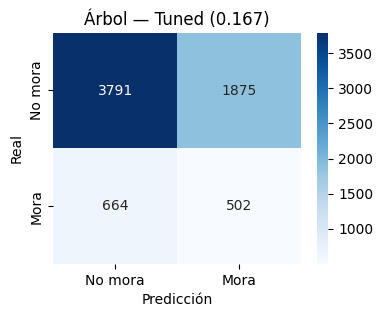

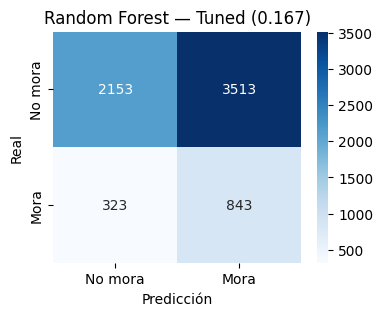

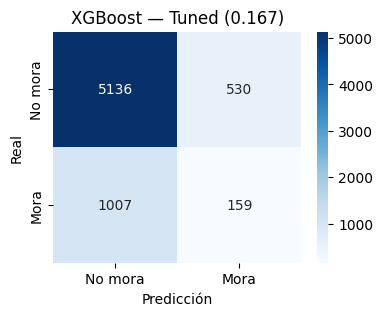

In [69]:
plot_cm(y_test, y_tree_tuned, "Árbol — Tuned (0.167)")
plot_cm(y_test, y_rf_tuned, "Random Forest — Tuned (0.167)")
plot_cm(y_test, y_xgb_tuned, "XGBoost — Tuned (0.167)")

## 11. Errores por Clínica & Asesor (Versión Ajustada)

In [70]:
test_df = test.copy()
test_df['pred_rf'] = y_rf_tuned
test_df['pred_log'] = y_pred_tuned

In [71]:
clinica_cols = [c for c in X_test.columns if c.startswith("CLINICA_")]

test_df['CLINICA'] = test_df[clinica_cols].idxmax(axis=1)

### 11.1 Errores por Clínica

#### Random Forest

In [72]:
errores_rf_clinica = test_df.groupby('CLINICA').apply(
    lambda x: pd.Series({
        'Casos Totales': len(x),
        'Mora Real (%)': x['target_mora30'].mean()*100,
        'Pred Mora (%)': x['pred_rf'].mean()*100,
        'Falsos Negativos (FN)': ((x['target_mora30']==1) & (x['pred_rf']==0)).sum(),
        'Falsos Positivos (FP)': ((x['target_mora30']==0) & (x['pred_rf']==1)).sum(),
        'Verdaderos Positivos (TP)': ((x['target_mora30']==1) & (x['pred_rf']==1)).sum()
    })
)

errores_rf_clinica.sort_values('Falsos Negativos (FN)', ascending=False).head(15)

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\2086232853.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errores_rf_clinica = test_df.groupby('CLINICA').apply(


,Casos Totales,Mora Real (%),Pred Mora (%),Falsos Negativos (FN),Falsos Positivos (FP),Verdaderos Positivos (TP)
CLINICA,,,,,,
CLINICA_Dentix IBE Cra. 5 Ibague,344.0,16.279070,36.337209,33.0,102.0,23.0
CLINICA_Dentix BAQ Barranquilla Portal del Prado,719.0,20.027816,78.859527,29.0,452.0,115.0
CLINICA_Dentix MZL Cra. 23 Manizales,318.0,13.207547,40.880503,21.0,109.0,21.0
CLINICA_Dentix PSO Pasto,247.0,24.291498,63.562753,20.0,117.0,40.0
CLINICA_Dentix CLO Av. 100 Cali,442.0,14.479638,65.837104,20.0,247.0,44.0
CLINICA_Dentix BGA Cl 35 Bucaramanga,506.0,17.984190,72.529644,16.0,292.0,75.0
CLINICA_Dentix MTR Montería,263.0,21.292776,60.076046,15.0,117.0,41.0
CLINICA_Dentix BOG Plaza Imperial,311.0,16.398714,59.485531,15.0,149.0,36.0
CLINICA_Dentix CLO Cali Chipichape,209.0,18.660287,71.770335,14.0,125.0,25.0


##### Clínicas con más FN

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\1362359056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_fn_rf.index, x=top_fn_rf["Falsos Negativos (FN)"], palette="Reds")


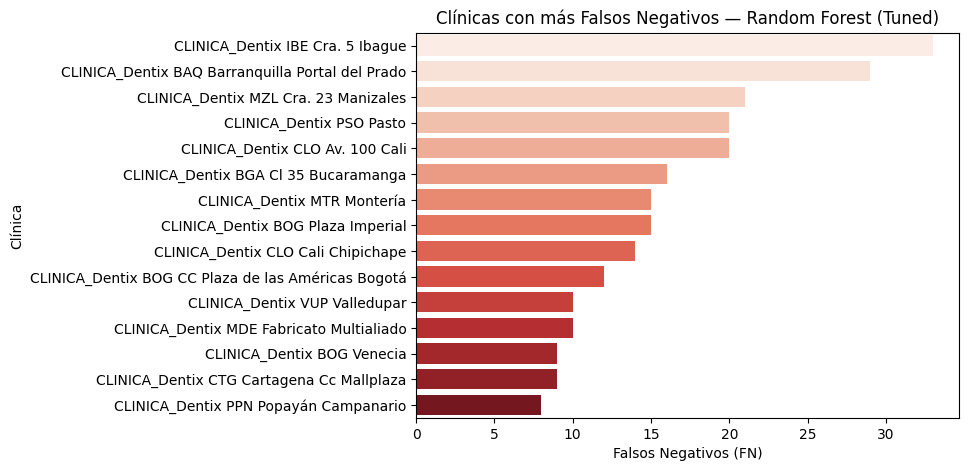

In [73]:
top_fn_rf = errores_rf_clinica.sort_values("Falsos Negativos (FN)", ascending=False).head(15)

plt.figure(figsize=(7,5))
sns.barplot(y=top_fn_rf.index, x=top_fn_rf["Falsos Negativos (FN)"], palette="Reds")
plt.title("Clínicas con más Falsos Negativos — Random Forest (Tuned)")
plt.xlabel("Falsos Negativos (FN)")
plt.ylabel("Clínica")
plt.show()

#### Regresión Logística

In [74]:
errores_log_clinica = test_df.groupby('CLINICA').apply(
    lambda x: pd.Series({
        'Casos Totales': len(x),
        'Mora Real (%)': x['target_mora30'].mean()*100,
        'Pred Mora (%)': x['pred_log'].mean()*100,
        'Falsos Negativos (FN)': ((x['target_mora30']==1) & (x['pred_log']==0)).sum(),
        'Falsos Positivos (FP)': ((x['target_mora30']==0) & (x['pred_log']==1)).sum(),
        'Verdaderos Positivos (TP)': ((x['target_mora30']==1) & (x['pred_log']==1)).sum()
    })
)

errores_log_clinica.sort_values('Falsos Negativos (FN)', ascending=False).head(15)

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\2036187958.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errores_log_clinica = test_df.groupby('CLINICA').apply(


,Casos Totales,Mora Real (%),Pred Mora (%),Falsos Negativos (FN),Falsos Positivos (FP),Verdaderos Positivos (TP)
CLINICA,,,,,,
CLINICA_Dentix BAQ Barranquilla Portal del Prado,719.0,20.027816,54.102921,44.0,289.0,100.0
CLINICA_Dentix PSO Pasto,247.0,24.291498,21.052632,44.0,36.0,16.0
CLINICA_Dentix IBE Cra. 5 Ibague,344.0,16.279070,22.383721,37.0,58.0,19.0
CLINICA_Dentix MTR Montería,263.0,21.292776,42.965779,30.0,87.0,26.0
CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,386.0,16.062176,40.673575,28.0,123.0,34.0
CLINICA_Dentix CLO Av. 100 Cali,442.0,14.479638,48.416290,28.0,178.0,36.0
CLINICA_Dentix BGA Cl 35 Bucaramanga,506.0,17.984190,50.988142,28.0,195.0,63.0
CLINICA_Dentix MDE Fabricato Multialiado,231.0,14.718615,9.090909,27.0,14.0,7.0
CLINICA_Dentix BOG Plaza Imperial,311.0,16.398714,38.263666,25.0,93.0,26.0


##### Clínicas con más FN

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\2134309509.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_fn_log.index, x=top_fn_log["Falsos Negativos (FN)"], palette="Blues")


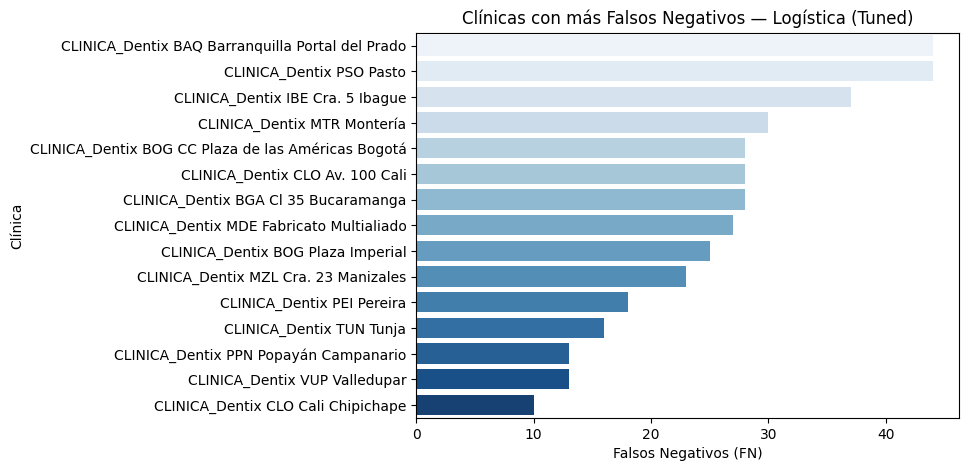

In [75]:
top_fn_log = errores_log_clinica.sort_values("Falsos Negativos (FN)", ascending=False).head(15)

plt.figure(figsize=(7,5))
sns.barplot(y=top_fn_log.index, x=top_fn_log["Falsos Negativos (FN)"], palette="Blues")
plt.title("Clínicas con más Falsos Negativos — Logística (Tuned)")
plt.xlabel("Falsos Negativos (FN)")
plt.ylabel("Clínica")
plt.show()

### 11.2 Errores por Asesor

In [76]:
df_asesores = pd.read_csv("../../data/interim/04_outliers_cleaned.csv")

test_df = test.copy()
test_df['pred_rf'] = y_rf_tuned
test_df['pred_log'] = y_pred_tuned
test_df['prob_rf'] = probs_rf
test_df['prob_log'] = probs_log

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\1444512264.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_asesores = pd.read_csv("../../data/interim/04_outliers_cleaned.csv")


In [77]:
test_df = test_df.merge(
    df_asesores[['TRANSACTION ID', 'COMERCIAL']], 
    on='TRANSACTION ID',
    how='left'
)

In [78]:
errores_rf_asesor = test_df.groupby('COMERCIAL').apply(
    lambda x: pd.Series({
        'Casos Totales': len(x),
        'Mora Real (%)': x['target_mora30'].mean()*100,
        'Pred Mora (%)': x['pred_rf'].mean()*100,
        'FN': ((x['target_mora30']==1) & (x['pred_rf']==0)).sum(),
        'FP': ((x['target_mora30']==0) & (x['pred_rf']==1)).sum(),
        'TP': ((x['target_mora30']==1) & (x['pred_rf']==1)).sum()
    })
)

errores_rf_asesor.sort_values("FN", ascending=False).head(15)

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\4191736100.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errores_rf_asesor = test_df.groupby('COMERCIAL').apply(


,Casos Totales,Mora Real (%),Pred Mora (%),FN,FP,TP
COMERCIAL,,,,,,
colte_dherrerag,145.0,16.551724,14.482759,21.0,18.0,3.0
colte_ccdentixbaq008,201.0,23.383085,75.621891,12.0,117.0,35.0
colte_ccdrendon,187.0,11.229947,43.850267,11.0,72.0,10.0
colte_ccdentixpso002,116.0,23.275862,51.724138,11.0,44.0,16.0
colte_cckcogollo,110.0,26.363636,60.909091,10.0,48.0,19.0
colte_dvmarin,185.0,17.297297,69.729730,10.0,107.0,22.0
colte_ccdentixibe003,81.0,16.049383,32.098765,8.0,21.0,5.0
colte_ccdentixpso003,100.0,26.000000,67.000000,8.0,49.0,18.0
colte_ccdentixppn005,161.0,16.149068,62.111801,8.0,82.0,18.0


In [79]:
errores_log_asesor = test_df.groupby('COMERCIAL').apply(
    lambda x: pd.Series({
        'Casos Totales': len(x),
        'Mora Real (%)': x['target_mora30'].mean()*100,
        'Pred Mora (%)': x['pred_log'].mean()*100,
        'FN': ((x['target_mora30']==1) & (x['pred_log']==0)).sum(),
        'FP': ((x['target_mora30']==0) & (x['pred_log']==1)).sum(),
        'TP': ((x['target_mora30']==1) & (x['pred_log']==1)).sum()
    })
)

errores_log_asesor.sort_values("FN", ascending=False).head(15)

C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\2965047213.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errores_log_asesor = test_df.groupby('COMERCIAL').apply(


,Casos Totales,Mora Real (%),Pred Mora (%),FN,FP,TP
COMERCIAL,,,,,,
colte_ccdentixbaq010,185.0,21.621622,31.891892,22.0,41.0,18.0
colte_ccdentixpso002,116.0,23.275862,18.103448,22.0,16.0,5.0
colte_ccdentixpso003,100.0,26.000000,18.000000,19.0,11.0,7.0
colte_dherrerag,145.0,16.551724,15.862069,19.0,18.0,5.0
colte_cckcogollo,110.0,26.363636,42.727273,16.0,34.0,13.0
colte_lpaez,186.0,15.053763,33.870968,16.0,51.0,12.0
colte_ccdentixbog059,169.0,18.343195,33.727811,16.0,42.0,15.0
colte_dvmarin,185.0,17.297297,55.675676,15.0,86.0,17.0
colte_ccdentixmon003,103.0,17.475728,42.718447,11.0,37.0,7.0


C:\Users\kirad\AppData\Local\Temp\ipykernel_9716\52050498.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_fn.index, x=top_fn["FN"], palette="Reds")


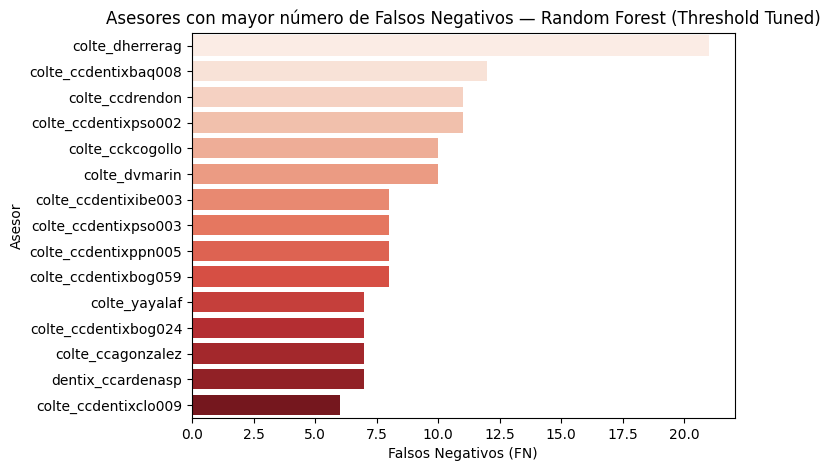

In [80]:
top_fn = errores_rf_asesor.sort_values("FN", ascending=False).head(15)

plt.figure(figsize=(7,5))
sns.barplot(y=top_fn.index, x=top_fn["FN"], palette="Reds")
plt.title("Asesores con mayor número de Falsos Negativos — Random Forest (Threshold Tuned)")
plt.xlabel("Falsos Negativos (FN)")
plt.ylabel("Asesor")
plt.show()